**Independent Component Analysis (ICA) Notebook**

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, non_negative_factorization

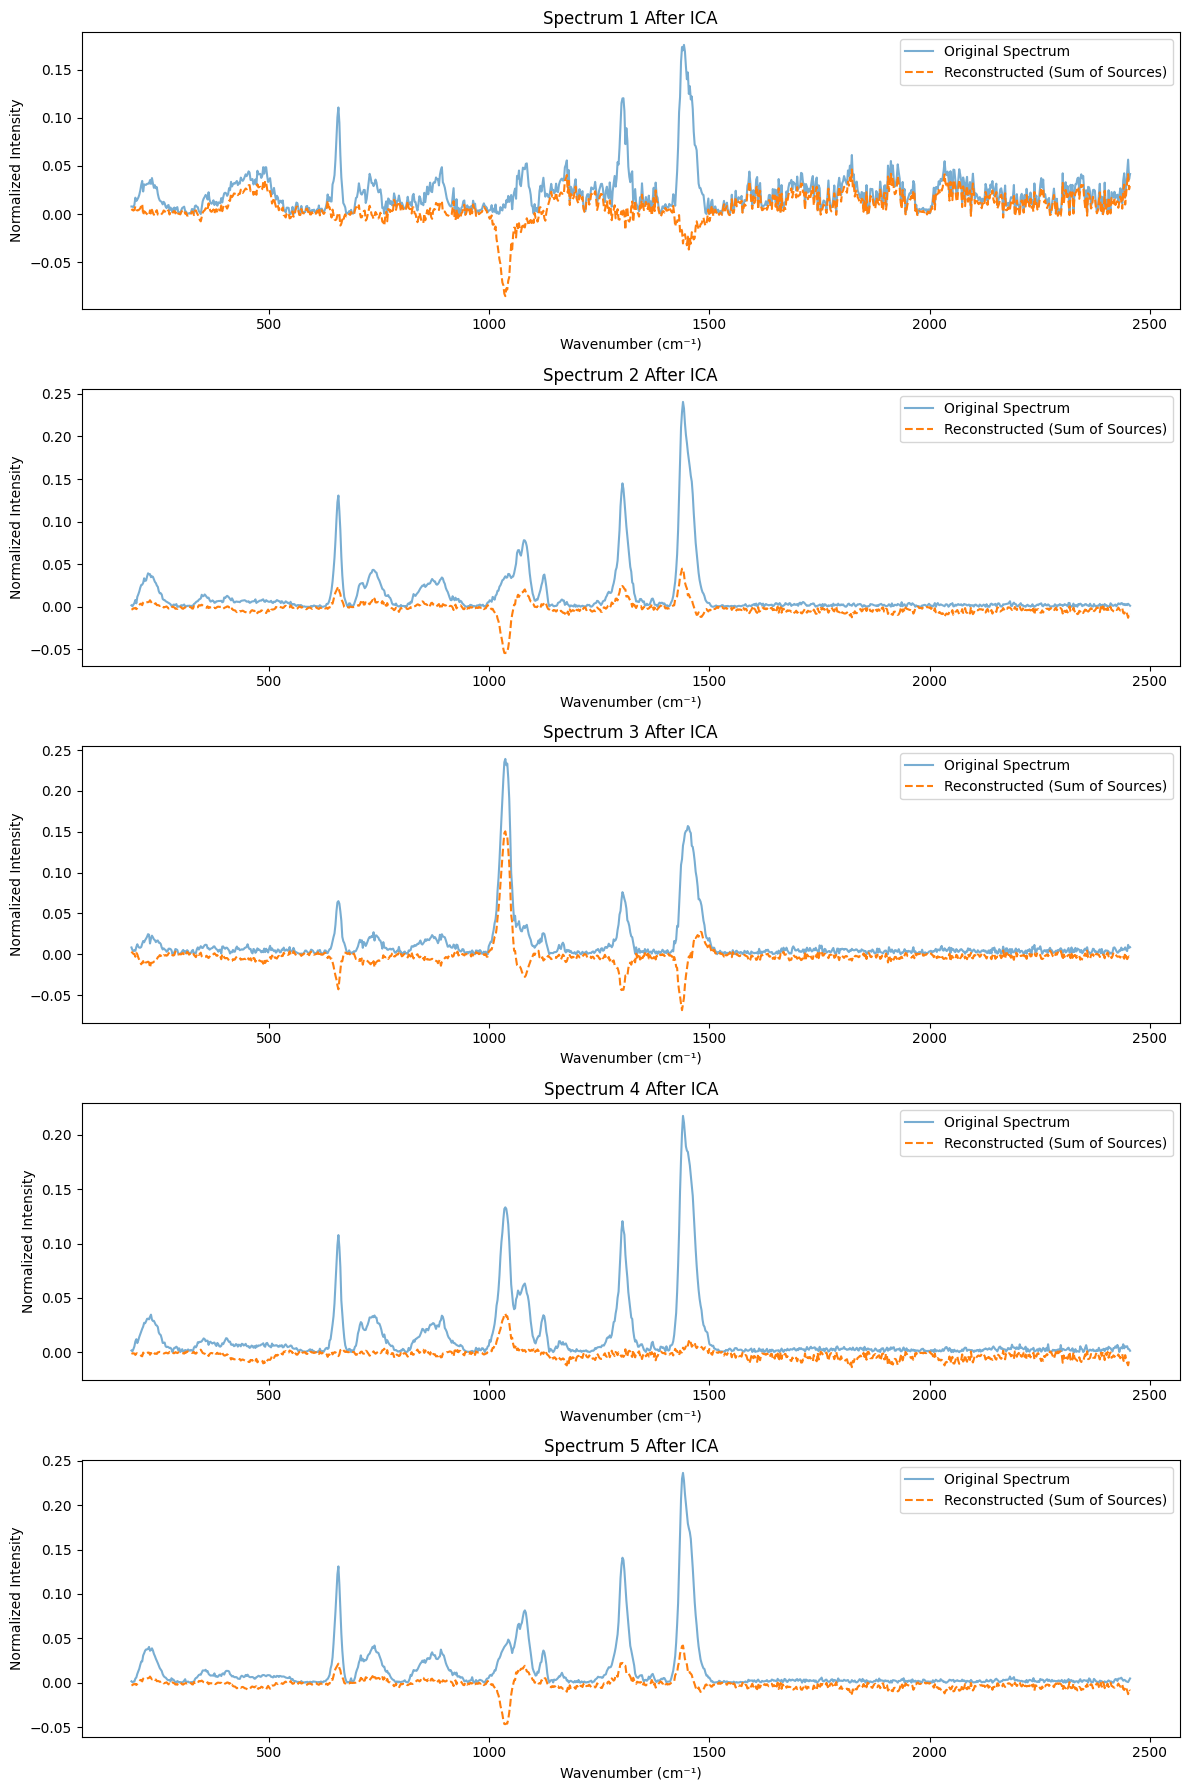

In [5]:
# Load the query dataset
query_df = pd.read_csv('test.csv')

# Identify wavenumber columns (exclude 'Label 1' and 'Label 2')
wavenumber_cols = [col for col in query_df.columns if col.replace('.', '', 1).isdigit()]
wavenumbers = np.array(wavenumber_cols, dtype=float)
spectra_raw = query_df[wavenumber_cols].values

# Baseline correction and normalization
def baseline_AsLS(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, spec in enumerate(arr):
        bkg = baseline_AsLS(spec)
        corr = spec - bkg
        nrm = np.linalg.norm(corr)
        normed = corr / nrm if nrm else corr
        normed = np.abs(normed)  # ✅ Make all values positive, element-wise
        out[i] = normed
    return out

spectra_preprocessed = preprocess(spectra_raw)

# Apply ICA to the first 5 spectra as a mini-batch (5 samples, N features)
subset = spectra_preprocessed[:5]
ica = FastICA(n_components=2, random_state=0)
try:
    sources = ica.fit_transform(subset)  # shape: (5, n_components)
    mixing = ica.mixing_.T               # shape: (2, n_features)
    reconstructed = sources @ mixing     # shape: (5, n_features)
except Exception as e:
    print("ICA failed:", e)
    reconstructed = subset  # fallback

# Plot original vs. reconstructed components
fig, axs = plt.subplots(5, 1, figsize=(12, 18))
for i in range(5):
    axs[i].plot(wavenumbers, spectra_preprocessed[i], label='Original Spectrum', alpha=0.6)
    axs[i].plot(wavenumbers, reconstructed[i], label='Reconstructed (Sum of Sources)', linestyle='--')
    axs[i].set_title(f'Spectrum {i+1} After ICA')
    axs[i].legend()
    axs[i].set_xlabel('Wavenumber (cm⁻¹)')
    axs[i].set_ylabel('Normalized Intensity')

plt.tight_layout()
plt.show()
